# Introduction
The following examples show how to use the **grand** (**GR**oup **AN**omaly **D**etection) library to monitor systems (or units) that generate data over time. The library allows to detect anomalies/deviations in a streaming fashion, and has models for both *individual* and *group* anomaly detection.

In *individual* anomaly detection, a system is compared against a fixed reference dataset ([section 1](#section1)), or against its own past historical data ([section 2](#section2)). In *group* anomaly detection, each target system is compared against a group of other systems ([section 3](#section3)).

- [Section 1: Stationary streaming data](#section1)
- [Section 2: Non-stationary streaming data with seasonality / periodicity](#section2)
- [Section 3: Group-based anomaly detection in non-stationary streaming data](#section3)

Installation (development version):
```bash
$ git clone https://github.com/caisr-hh/group-anomaly-detection.git
$ cd group-anomaly-detection
$ pip install .
```

Development version at:
https://github.com/Mohamed-Rafik-Bouguelia/group-anomaly-detection

In [1]:
# NOTE: run this cell before anything else
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from grand import IndividualAnomalyInductive, IndividualAnomalyTransductive, GroupAnomaly
from grand.datasets import load_artificial, load_vehicles

import grand
print("VERSION:", grand.__version__)

VERSION: 0.2.0


<a id='section1'></a>
# 1. Stationary streaming data
Let's start with the simplest senario: a stationary data stream. The observations in a stationary data stream are not dependent on time; they are sampled iid from an unknown underlying distribution. The following is an example of an artificial multivariate time-series (two-features) which do not have trend or seasonal effects.

            Feature 0  Feature 1
Date                            
1959-01-01         35  20.835502
1959-01-02         32  19.059137
1959-01-03         30  21.119310
1959-01-04         31  12.945256
1959-01-05         44  29.281085


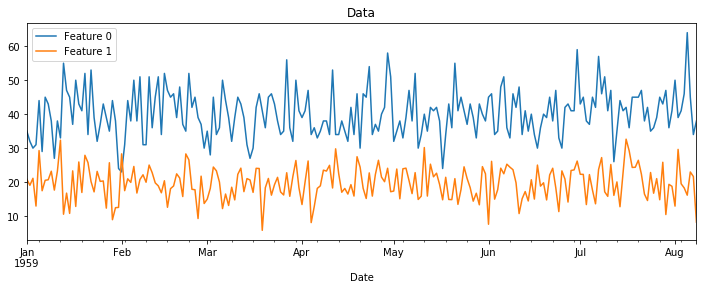

In [2]:
df0 = pd.read_csv('data/stationary-0.csv', header=0, index_col=0, parse_dates=True)
print(df0.head(5))

df0.plot(figsize=(12, 4), title="Data")
plt.show()

To look for anomalies in such a stationary data stream, we can create an anomaly detection model using `IndividualAnomalyInductive`. We fit the model to a fixed reference dataset `X_fit` which is assumed to be normal (i.e. without anomalies). For example, `X_fit` can be the first $n$ samples from the stream.

The following is an instance of the `IndividualAnomalyInductive` model:
```python
model = IndividualAnomalyInductive(
            non_conformity = "knn",   # Strangeness measure, e.g. "knn" or "median"
            k = 20                    # Used if non_conformity is "knn"
            w_martingale = 15,        # Window size used for computing the deviation level
            dev_threshold = 0.6,      # Threshold on the deviation level (in [0, 1])
            columns=None              # Optional feature names (for interpreting the results)
)

model.fit(X_fit)
```

First, for each new data-point $x_t$ (in the above dataset $x_t \in \mathbb{R}^2$) received at time $t$, the model computes a non-conformity (or strangeness) measure $S_t$. This measure is specified by the parameter `non_conformity`. If it is set to `"median"`, then the distance from $x_t$ to the median of `X_fit` is used. If it is set to `"knn"`, then the average distance from $x_t$ to its $k$ nearest neighbours in `X_fit` is used. Other non-conformity measures are also possible (e.g. based on clustering and density estimation) and will be included in later versions.

Second, a p-value $p_t$ is computed at time $t$ as follows:
<img src="imgs/pvalue.png" width="300px" style="float: right" />
$$
p_t = Pr(S > S_t) \approx \frac{\#\{x_i \in \text{X_fit} \mid S_i > S_t\}}{n} \in [0, 1],
$$
where $n = |\text{X_fit}|$ is the cardinality of the set $\text{X_fit}$.
If the new data-points $\{x_0 \dots x_t\}$ from the stream come from the same distribution as the data-points in `X_fit`, then their strangeness measures $\{S_0 \dots S_t\}$ will also come from the same distribution as the strangeness of those in `X_fit`. In this case, the p-values $\{p_0 \dots p_t\}$ will be uniformly distributed in $[0, 1]$.

Finally, to detect collective anomalies, a deviation level $M_t$ is computed based on the last $w$ p-values $\{p_{t-w}, \dots, p_t \}$. This is done by testing how uniform are these p-values, using the following incremental martingale test:
$$
M_t = \frac{2}{w} \sum_{i = t-w}^{t} \left ( -p_i + \frac{1}{2} \right ),
$$
where $w$ is referred to as `w_martingale` is the code. This deviation level $M_t$ measures how uniform the p-values are over time. If the new data-points comes from the same distribution as `X_fit`, then the p-values will be uniformly distributed in $[0, 1]$ and the deviation level will be low (close to 0).

The usage of the `IndividualAnomalyInductive` model is illustrated in the following code. After running the code, you will see that the deviation level is always low (close to 0) as long as the data continues to come from the same distribution as `X_fit`.

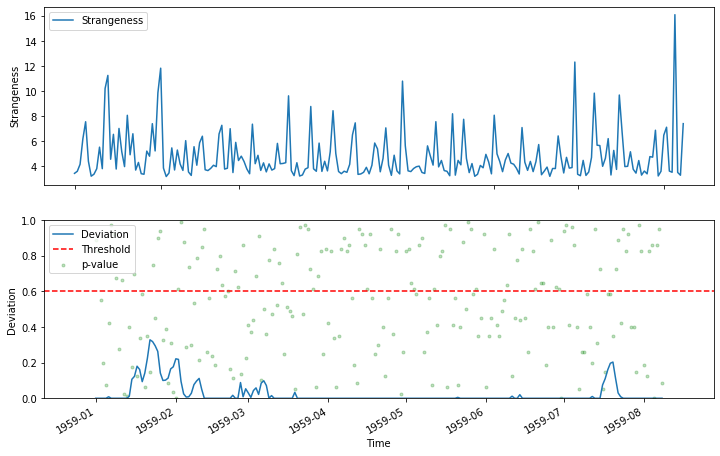

In [3]:
# Create a model using IndividualAnomalyInductive
model = IndividualAnomalyInductive(non_conformity = "knn", k = 20)

# Fit the model to a fixed subset of the data
X_fit = df0.head(n = 80).values
model.fit(X_fit)

# At each time step t, a data-point x comes from the stream
for t, x in zip(df0.index, df0.values):
    info = model.predict(t, x)
    print(info, end="\r", flush=True)

# Plot strangeness and deviation level over time
model.plot_deviations(figsize=(12, 8), plots=["strangeness", "deviation", "pvalue", "threshold"])

## 1.1. Deviation due to a change in the data distribution
In the following dataset `stationary-1.csv`, a period of time (after August) is added where the data start to slowly deviate and come from a different distribution than `X_fit`.

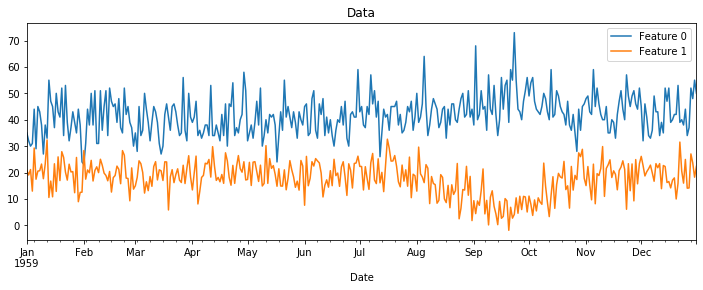

In [4]:
df1 = pd.read_csv('data/stationary-1.csv', header=0, index_col=0, parse_dates=True)
df1.plot(figsize=(12, 4), title="Data")
plt.show()

After running the following code, you will notice that the deviation level increased significantly (indicating an anomaly) during the period where the change in the data distribution happened.

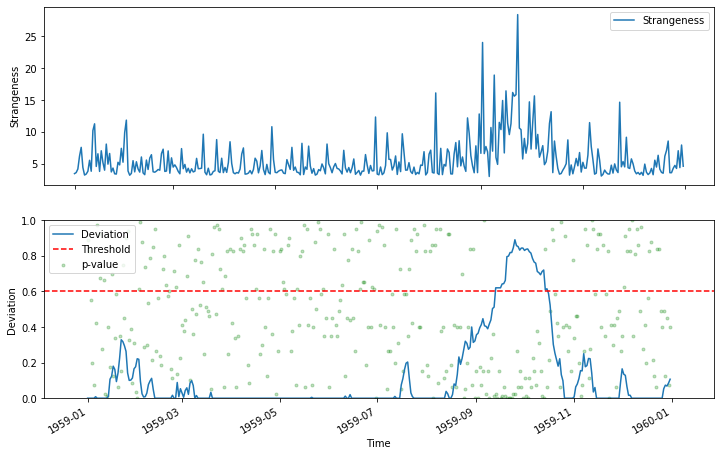

In [5]:
model = IndividualAnomalyInductive(non_conformity = "knn", k = 20)
model.fit(X_fit)

for t, x in zip(df1.index, df1.values):
    info = model.predict(t, x)
    print(info, end="\r", flush=True)

model.plot_deviations(figsize=(12, 8), plots=["strangeness", "deviation", "pvalue", "threshold"])

Feature 1, score: 64.94%
Feature 0, score: 35.06%


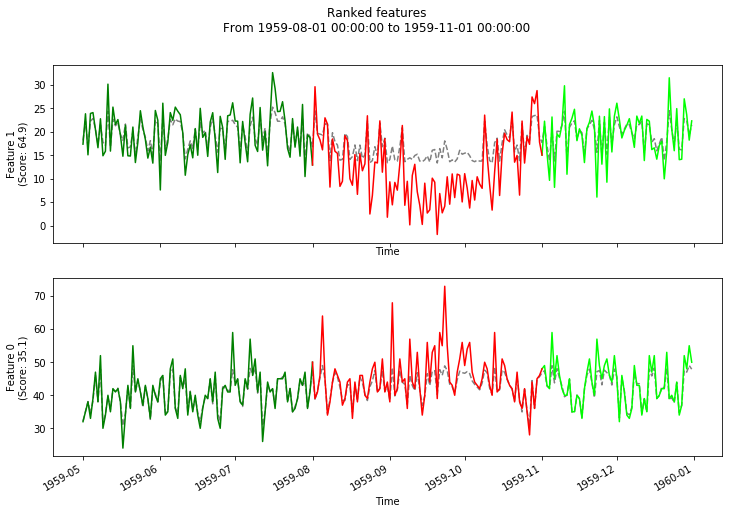

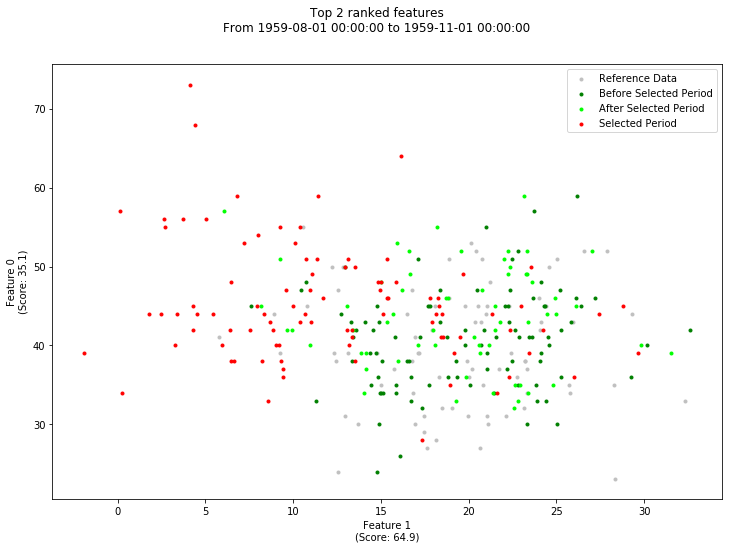

In [6]:
t1 = datetime(1959, 8, 1)
t2 = datetime(1959, 11, 1)

model.plot_explanations(t1, t2, k_features=2, figsize=(12, 8))

## 1.2. The effect of outliers on the deviation level
The following dataset `stationary-2.csv` shows the same data as the previous one, but with few outliers arround mid April.

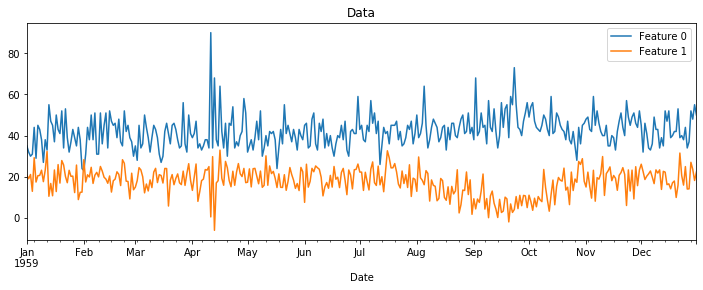

In [7]:
df2 = pd.read_csv('data/stationary-2.csv', header=0, index_col=0, parse_dates=True)
df2.plot(figsize=(12, 4), title="Data")
plt.show()

After running the following code, you will notice that such few outliers do not affect the deviation level as it is computed based on several consecutive samples from the stream. These outliers are however captured by the strangeness score, which is computed on individual samples from the stream.

The **strangeness score** reflects the non-conformity (strangeness) of individual samples, while the **deviation level** reflects **collective anomalies** or a consistent change in the data distribution over time.

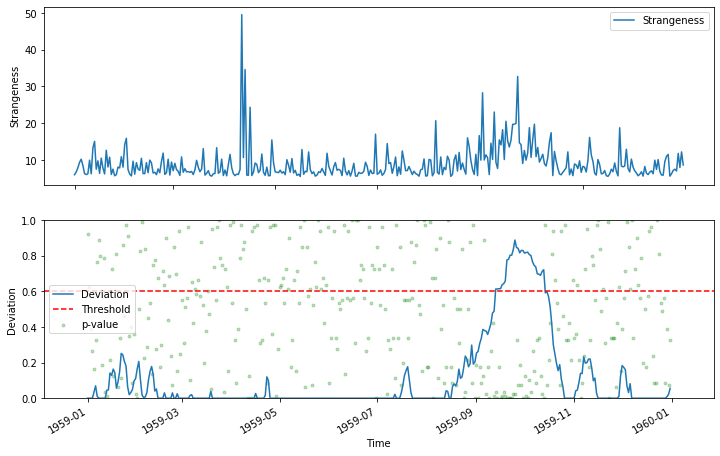

In [8]:
model = IndividualAnomalyInductive(non_conformity = "knn", k = 50)
model.fit(X_fit)

for t, x in zip(df2.index, df2.values):
    info = model.predict(t, x)
    print(info, end="\r", flush=True)

model.plot_deviations(figsize=(12, 8), plots=["strangeness", "deviation", "pvalue", "threshold"])

<a id='section2'></a>
# 2. Non-stationary streaming data with seasonality / periodicity
Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time.

## 2.1. Reference data based on time: Taxi passengers example
The following dataset `nyc_taxi.csv` consists of a univariate time series representing the number of NYC taxi passengers aggregated into 30 minute buckets (for 7 months of data). The plot below shows a subset of the data corresponding to the first two weeks of July (starting on Tuesday).

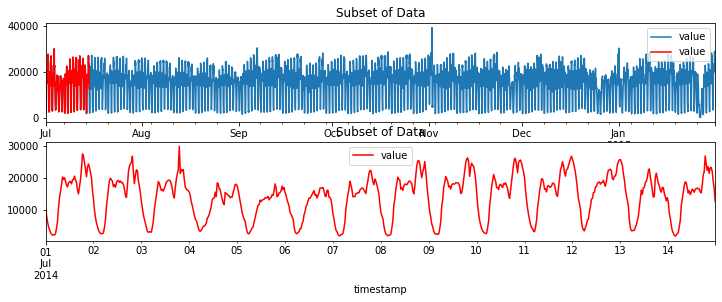

In [9]:
df = pd.read_csv('data/nyc_taxi.csv', header=0, index_col=0, parse_dates=True)
subset_df = df.head(336*2)

fig, (ax1, ax2) = plt.subplots(2)
df.plot(figsize=(12, 4), title="Full Dataset", ax=ax1)
subset_df.plot(figsize=(12, 4), title="Subset of Data", ax=ax1, color="red")
subset_df.plot(figsize=(12, 4), title="Subset of Data", ax=ax2, color="red")
plt.show()

This non-stationary dataset is however periodic as we see similar patterns repeating over days and weeks.

One way to look for anomalies in such data stream is to create an anomaly detection model using the class `IndividualAnomalyTransductive`. This model takes a parameter `ref_group` specifying the criteria to use in orde to construct a reference dataset. Each time the `predict` function is called for a new sample `x` at time `t`, a reference dataset is constructed from historical data (prior to `t`) based on the criteria specified in `ref_group`.

The following is an instance of the `IndividualAnomalyTransductive` model:
```python
model = IndividualAnomalyTransductive(
            ref_group = ["day-of-week"] # Criteria to use to construct reference data
            external_percentage = 0.3   # Percentage of samples to pick from historical data
            
            # The following parameters are the same as in IndividualAnomalyInductive
            non_conformity = "knn",     # Strangeness measure, e.g. "knn" or "median"
            k = 20                      # Used if non_conformity is "knn"
            w_martingale = 15,          # Window size used for computing the deviation level
            dev_threshold = 0.6,        # Threshold on the deviation level (in [0, 1])
            columns=None                # Optional feature names (for interpreting the results)
)
```

The parameter `ref_group` can be:
1. One or more criteria from the following: `["hour-of-day", "day-of-week", "day-of-month", "week-of-year", "month-of-year", "season-of-year"]`.
2. Or can be set to `ref_group = "external"` if we want to specify our own criteria which doesn't necessarily depend on time. For example, when we want to compare the current sample against historical samples where the outside temperature was similar to the current temperature.
3. Or can be set to a callable `function(history_times, history_data, current_time, current_data)` implemented by the user. This way, any criteria for selecting the reference data can easily be implemented.

In the code below, we have set `ref_group = ["hour-of-day", "day-of-week"]` for the Taxi dataset. This means that each new sample `x_t`, received at current time `t`, will be compared against historical samples where the *hour-of-the-day* was the same as the current hour and the *day-of-the-week* was the same as the current weekday.

In [10]:
model = IndividualAnomalyTransductive(ref_group = ["hour-of-day", "day-of-week"], w_martingale = 100)

for t, x in zip(df.index, df.values):
    info = model.predict(t, x)
    print("Time: {} ==> strangeness: {}, deviation: {}".format(t, info.strangeness, info.deviation), end="\r")

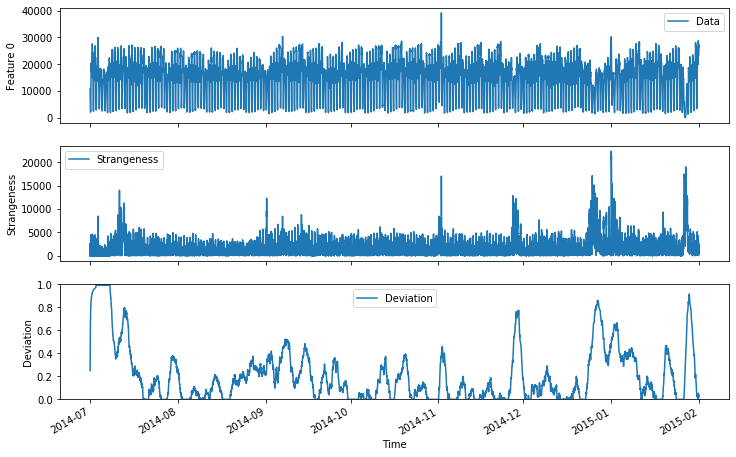

In [11]:
# Plot strangeness and deviation level over time
model.plot_deviations(figsize=(12, 8), plots=["data", "strangeness", "deviation"])

The following code highlights periods where some events occured (e.g. the NYC marathon, Thanksgiving, Christmas, New Year days, and a snow storm) that lead to a high anomaly score.

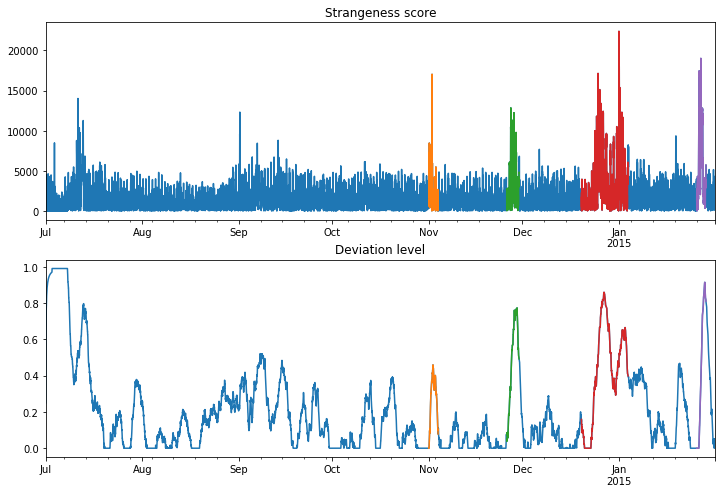

In [12]:
periods = [
    ("2014-11-01", "2014-11-03"),  # NY city Marathon on 2014-11-02
    ("2014-11-26", "2014-11-29"),  # Thanksgiving on 2014-11-27
    ("2014-12-20", "2015-01-03"),  # Christmas and new year days
    ("2015-01-26", "2015-01-28")   # Bad weather (snow storm)
]

stats = model.get_stats()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
stats["strangeness"].plot(ax=ax1, title="Strangeness score")
stats["deviation"].plot(ax=ax2, title="Deviation level")
for frm, to in periods:
    stats[frm:to]["strangeness"].plot(ax=ax1)
    stats[frm:to]["deviation"].plot(ax=ax2)

plt.show()

Let's pick the deviation at the period of the end of year (e.g. 2014-12-24 to 2014-12-29) and try to explain it using `model.plot_explanations(...)`. After running the following code, we can see that the number of taxi passengers (feature 0) was clearly lower than the closest expected number (shown as dashed line).

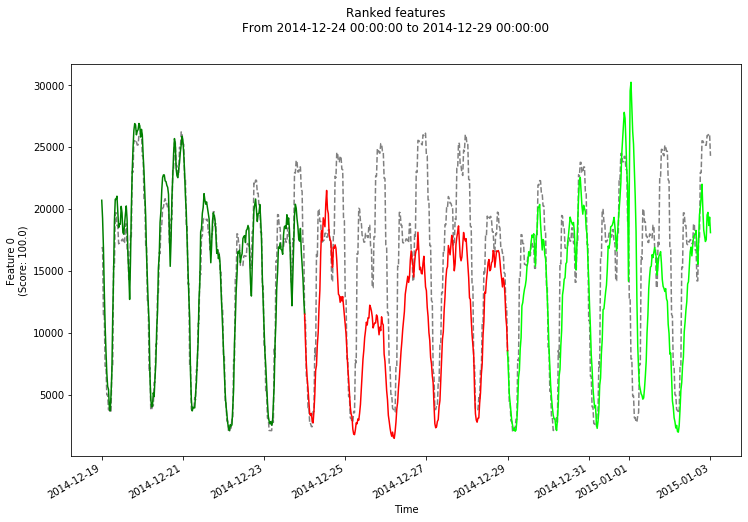

In [13]:
t1 = datetime(2014, 12, 24)
t2 = datetime(2014, 12, 29)

model.plot_explanations(t1, t2, figsize=(12, 8))

To better explain this deviation, we can also search for other deviations which are similar to this one. To do so, we use `model.get_similar_deviations(...)`.

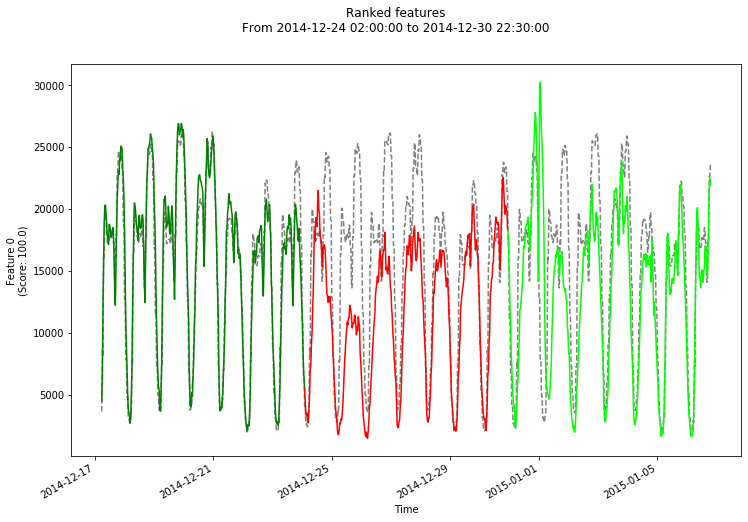

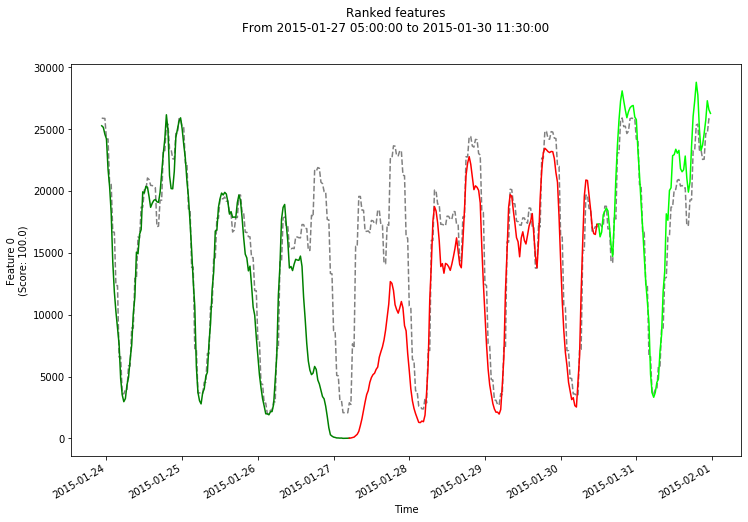

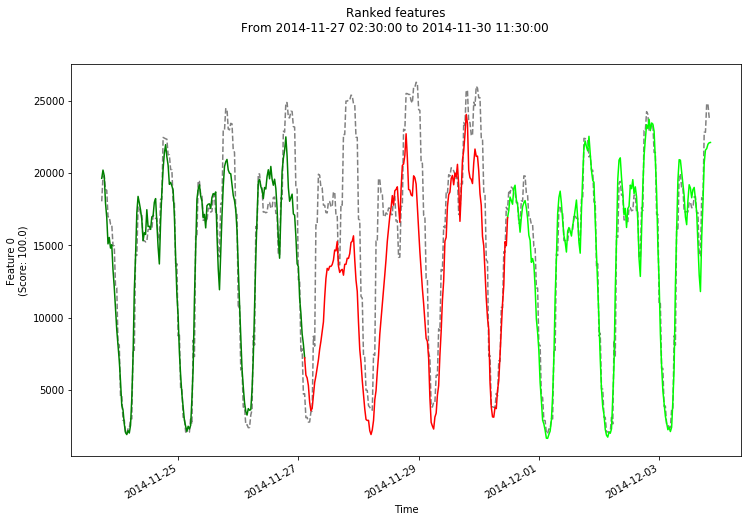

In [14]:
deviations = model.get_similar_deviations(t1, t2, k_devs=3, min_len=20, dev_threshold=0.3)

for dev_signature, frm, to in deviations:
    model.plot_explanations(frm, to, figsize=(12, 8))

## 2.2. Reference data based on external criteria: Heat-pump example

Let's consider another read dataset consisting of data from a heat-pump. The data is described by features such as the average hot-gas, condensor and switch-valve. The distribution of this data is affected by an external condition: the outside temperature. The following code loads the dataset and plots it.

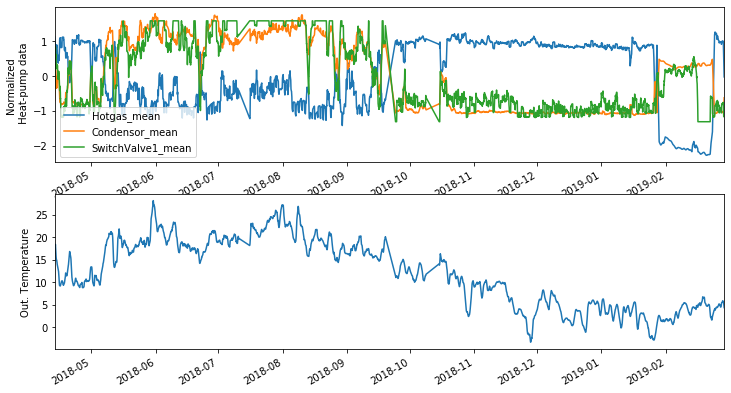

In [15]:
normalize = lambda df: (df - df.mean()) / df.std()

hp = pd.read_csv('data/heatpump-1.csv', header=0, index_col=0, parse_dates=True)
hp_init = hp.head(1000)

out_temps = hp.iloc[:, -1]
hp = normalize( hp.iloc[:, :-1] )

out_temps_init = hp_init.iloc[:, -1]
hp_init = normalize( hp_init.iloc[:, :-1] )
X_init = [(t, x, ot) for (t, x, ot) in zip(hp_init.index, hp_init.values, out_temps_init.values)]

fig, (ax1, ax2) = plt.subplots(2)
hp.plot(figsize=(12, 7), ax=ax1)
out_temps.plot(figsize=(12, 7), ax=ax2)
ax1.set_ylabel("Normalized \n Heat-pump data")
ax2.set_ylabel("Out. Temperature")
plt.show()


The following code shows how to use the `IndividualAnomalyTransductive` model to compare each new data-point `x` at time `t` where the outside temperature is `ot`, against a subset of historical data where the outside temperature was similar similar to `ot`. Notice that `ref_group` is set to `ref_group="external"`, and that the function `model.predict(t, x, ot)` takes as a 3rd argument the outside temperature value at time `t`.

In [16]:
model = IndividualAnomalyTransductive(ref_group="external", w_martingale=100, columns=list(hp.columns))
model.init(X_init)

for t, x, ot in zip(hp.index, hp.values, out_temps):
    info = model.predict(t, x, ot)
    print("Time: {} ==> strangeness: {}, deviation: {}".format(t, info.strangeness, info.deviation), end="\r")

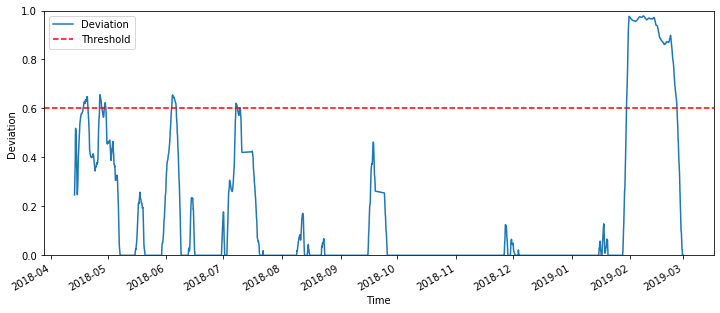

In [17]:
model.plot_deviations(figsize=(12, 5), plots=["deviation", "threshold"])

To explain what happened during the period where the deviation level was high, we can use `model.plot_explanations(...)` as follows:

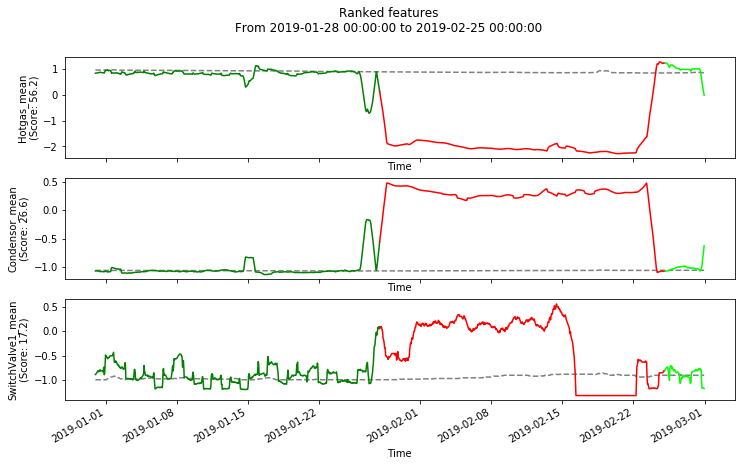

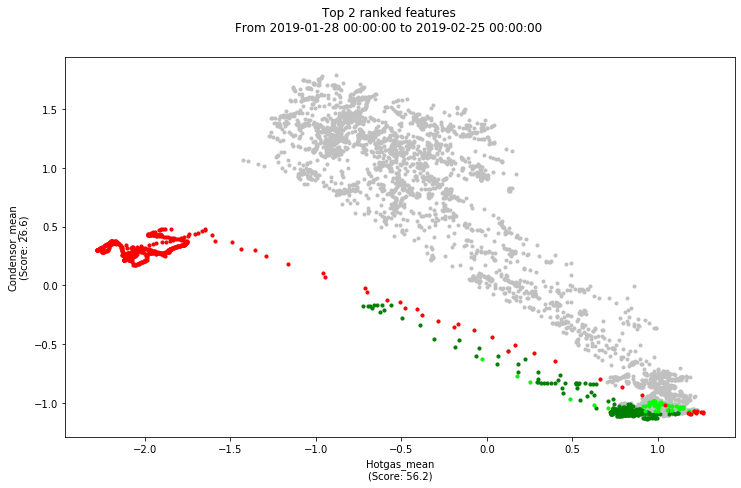

In [18]:
t1 = datetime(2019, 1, 28)
t2 = datetime(2019, 2, 25)

model.plot_explanations(t1, t2, figsize=(12, 7))

## 2.3. Selecting reference data with a user-defined function
It is possible to easily implement any other criteria for selecting the reference data. To do so, the `ref_group` parameter should be set to a user-defined function which takes the following arguments and returns a subset of the histirical data (history_data) :
- `history_times`: list of datetimes corresponding to the historical data
- `history_data`: list of historical data-points
- `current_time`: the current datetime
- `current_data`: the current data-point

This is illustrated in the following code on a simple artificial dataset.

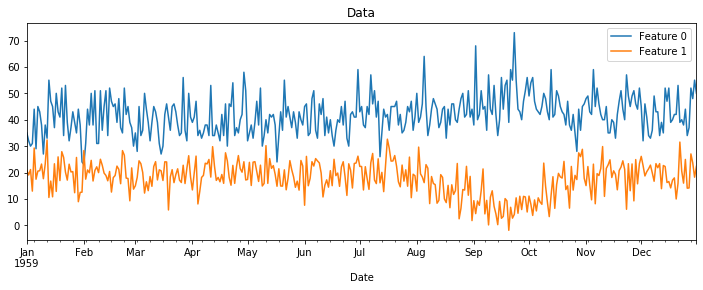

In [19]:
df1 = pd.read_csv('data/stationary-1.csv', header=0, index_col=0, parse_dates=True)
df1.plot(figsize=(12, 4), title="Data")
plt.show()

In the following example, if the user-defined function `select_ref_data(..)` returns (for instance) the last data-points from `history_data`, then the gradual deviation will not be detected (e.g. because the user is only interested in sudden changes/deviations). However, if the user-defined function returns (for instance) the last data-points from `history_data`, then the gradual deviation will be detected.

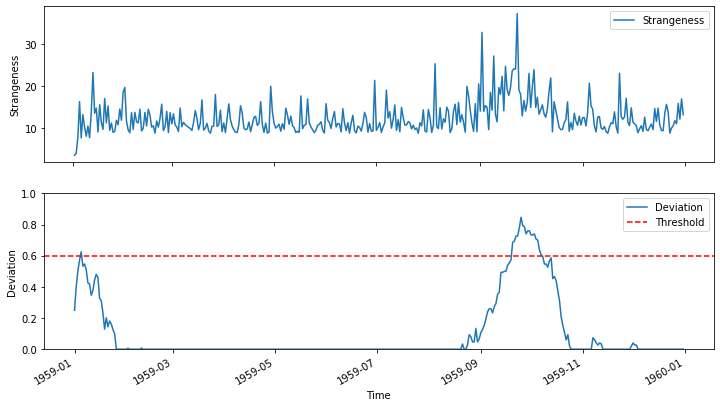

In [21]:
def select_ref_data(history_times, history_data, current_time, current_data):
    #return history_data[-20:]   # returns the 20 last data-points from history_data
    return history_data[:20]    # returns the 20 first data-points from history_data

model = IndividualAnomalyTransductive(ref_group = select_ref_data, non_conformity="knn")

for t, x in zip(df1.index, df1.values):
    info = model.predict(t, x)
    print(info, end="\r", flush=True)

model.plot_deviations(figsize=(12,7), plots=["strangeness", "deviation", "threshold"])

The class `IndividualAnomalyTransductive` assumes that there is some kind of periodicity and that there is sufficient historical data to construct a reference dataset for each new sample. However, it becomes not possible to use such model when:
- The external conditions that affects the distribution of the data are unknown.
- Or, when there is no sufficient amount of historical data (e.g. seasonality happens over years).
- Or, when there is no periodicity in the non-stationary data stream at all.

<a id='section3'></a>
# 3. Group-based anomaly detection in non-stationary streaming data
To detect anomalies in a given system, it is necessary to define what a *normal system behavior* is. With the `IndividualAnomalyInductive` detector, the data was assumed to be sampled from a stationary distribution, and the model was fitted to a fixed dataset representing the *normal system behavior*. With the `IndividualAnomalyTransductive` detector, some form of a *normal system behavior* was also required; for example, knowledge about the periodicity of the data, or the external factors affecting the data distribution over time.

In this section we see how to use the `GroupAnomaly` detector, which is usefull when the definition of what is normal is not fixed and the above-mentioned knowledge is not available.

## 3.1. Background
In the `GroupAnomaly` model, a group of several systems generate data over time (i.e. multiple non-stationary data streams). These systems are assumed to be subject to the same external conditions that influence their data distributions. An anomaly is detected when the data from a target system starts to change differently from the other systems.

The parameters of `GroupAnomaly` and their default values are as follows:

```python
model = GroupAnomaly(
    nb_units,                   # Number of units (i.e. systems)
    ids_target_units,           # Ids of the (target) units to diagnoise
    
    transformer = None,         # Transform each unit's data separately to make them more comparable
    w_transform = 30,           # Window size used when transformer is set to "slope" or "mean_pvalue"
    w_ref_group = "7days",      # Time window for the reference group
    
    non_conformity = "median",  # Strangeness measure: "median" or "knn"
    k = 20,                     # Used if non_conformity is "knn"
    w_martingale = 15)          # Window size for computing the deviation level
```

At each time step $t$, a list of data-points `x_units` is received. Each data-point `x_units[i]` corresponds to the $i^{th}$ system. The length of `x_units` should correspond to `nb_units` (i.e. `len(x_units) == nb_units`). A data-point $x_t^{(i)}$ at time $t$ from the $i^{th}$ target system, is compared against a reference dataset constructed from the data of the other systems during the past `w_ref_group` time period. The `predict` method is called as `infos = model.predict(t, x_units)` and returns a list of information. Each element `info` in `infos` contains information related to one target system (whose id was specified in `ids_target_units`).

```python
for t, x_units in dataset.stream():
    infos = model.predict(t, x_units)
```

## 3.2. GroupAnomaly() on vechiles datasets:
The following code loads a dataset consisting of data streaming from 19 vehicles (buses). This data consists in daily histograms (with 50 bins, i.e. 50 features) of the air pressure signale. The `GroupAnomaly` model is then used to monitor one of the vechile (vehicle number 0 in this example) by comparing its data, over time, against the other vechiles.

In [22]:
dataset = load_vehicles().normalize(with_std=True, with_mean=True)

nb_units = dataset.get_nb_units()  # Number of systems (vehicles)
ids_target_units = [0]             # Ids of the systems to monitor (here only the first vehicle)

model = GroupAnomaly(nb_units, ids_target_units, w_ref_group="7days", non_conformity="median")

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    print("Time: {} ==> {}".format(dt, infos[0]), end="\r", flush=True)

The following code uses `model.plot_deviations(..)` to plot the deviations corresponding to the vechiles that we specified in `ids_target_units` (vechile number 0 in this example).

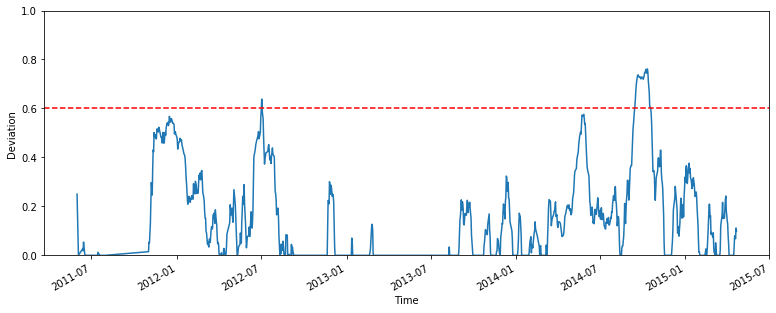

In [23]:
model.plot_deviations(figsize=(13, 5), plots=["deviation", "threshold"])

The following code plots an explanation the deviation that happened on vehicle 0 arround the period `t1 = "2014-8-1"` to `t2 = "2014-11-1"` using `model.plot_explanations(uid=0, from_time=t1, to_time=t2)`.

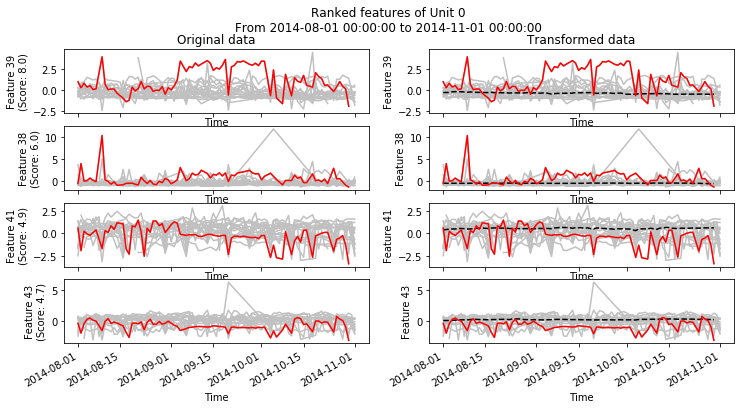

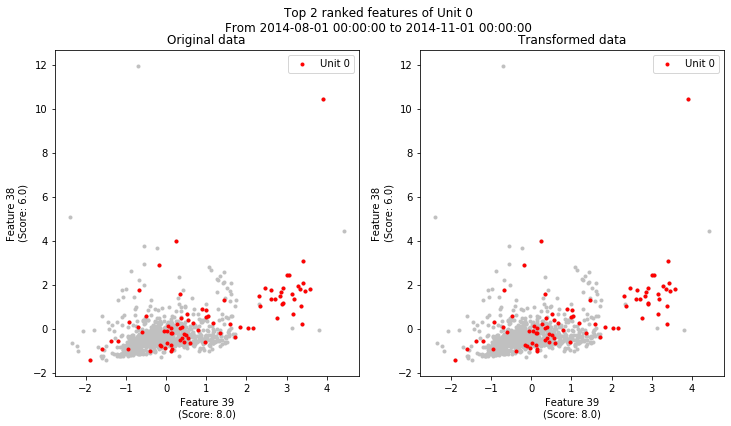

In [24]:
t1 = datetime(2014, 8, 1)
t2 = datetime(2014, 11, 1)

model.plot_explanations(uid=0, from_time=t1, to_time=t2, figsize=(12, 6))

Further, to search for other deviations similar to the one observed on vechile 0 between `t1` and `t2`, we can use the following code. Here `k_devs` specifies the number of deviations we want to get, `min_len` is the minimum number of samples to consider a valid deviation period, and `dev_threshold` is the threshold above which we consider a deviation.

```python
deviations = model.get_similar_deviations(0, t1, t2, k_devs=4, min_len=5, dev_threshold=0.4)
for dev_signature, from_time, to_time, uuid in deviations:
    print("Similar deviation: from {} to {}, Unit {}".format(from_time, to_time, uuid))
    # And we can further use: model.plot_explanations(uuid, from_time, to_time)
```

## 3.3. GroupAnomaly() on artificial datasets:
To better illustrate how the `GroupAnomaly` model works, we will use some built-in artificial datasets and use the default parameters shown above. These artificial datasets consist of univariate time-series from several systems. However, the code works as well on more general multivariate time-series data.

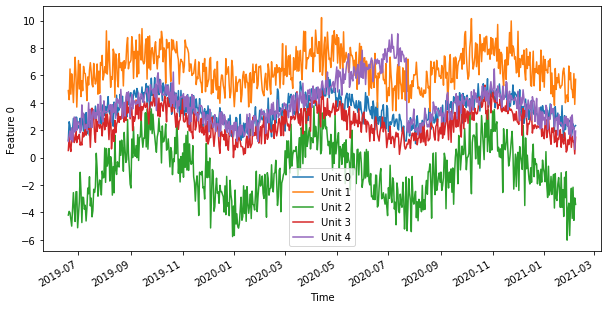

In [25]:
dataset_id = 0                             # You can try 0, 1, 2, 3, 4, 5 ... to load other datasets
dataset = load_artificial(dataset_id)      # Load artificial dataset number: dataset_id

nb_units = dataset.get_nb_units()          # Number of systems (data-streams)
ids_target_units = np.arange(nb_units)     # Ids of the systems to monitor (here all systems)

dataset.plot( figsize=(10, 5) )

As you see from the above figure, the last system (Unit 4) simulates an anomaly during some period of time. The 5 data-streams from the different systems (Unit 0 to 4) change similarly over time, but have different locations and scales.

One easy way to make the data from the different systems comparable, is to normalize the full data-streams. This can be done as follows using `dataset.normalize(..)`.

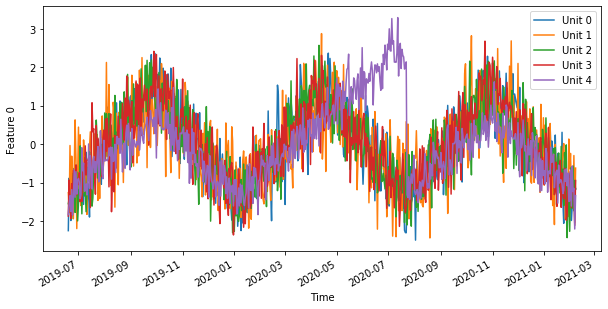

In [26]:
dataset.normalize(with_mean=True, with_std=True)
dataset.plot( figsize=(10, 5) )

As you may notice from the figure, the problem with this normalization is that it is affected by anomalies. For example, the data from Unit 4 (which was deviating between May and August) is now, after normalization, already deviating from the begining. Moreover, the normalized values of the abnormal part (between May and August) are not as high as before (relative to other values).

## 3.3.1. Data transformation
### Normalization can be sensitive to anomalies and outliers
Sometimes, it may be more conveniant to normalize the data from each system on-the-fly; i.e. only based on previously seen data from the stream. This can be acheived by setting the parameter `transformer` to `"mean_std_normalize"` when instanciating the `GroupAnomaly` class, as shown in the code below:

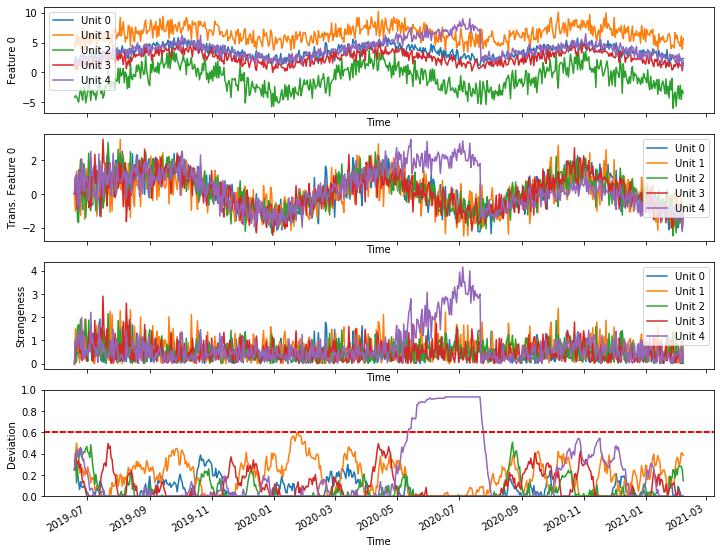

In [27]:
dataset = load_artificial(dataset_id)
model = GroupAnomaly(nb_units, ids_target_units, transformer = "mean_std_normalize")

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    
    for uid, info in enumerate(infos):
        print("Time: {} ==> {}".format(dt, info), end="\r", flush=True)

model.plot_deviations(figsize=(12, 10))

To explain the high deviation level on Unit 4 during the period May to August, relative to the other Units, we can use `model.plot_explanations(...)` as follows.

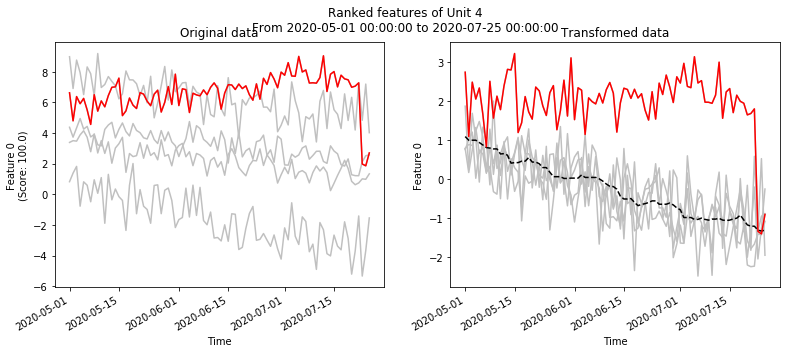

In [28]:
t1 = datetime(2020, 5, 1)
t2 = datetime(2020, 7, 25)

model.plot_explanations(uid=4, from_time=t1, to_time=t2, figsize=(13, 5))

However, the problem with such normalization (`transformer = "mean_std_normalize"`) is that it can be highly sensitive to outliers and anomalies in the data. To show this, consider the following example where we add few outliers to one of the systems (e.g. "Unit 3").

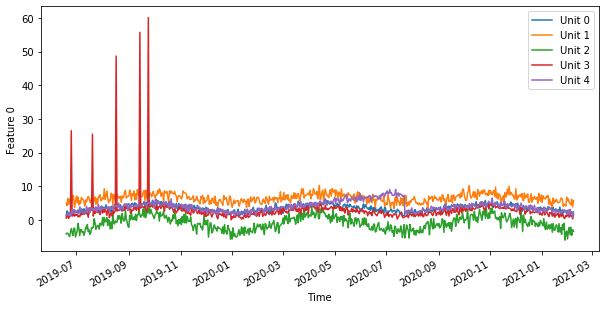

In [29]:
dataset = load_artificial(dataset_id)

# Adding few outliers to the data-stream of Unit 3
ids = np.random.randint(0, 100, size = 5)
df = dataset.dfs[3]
df.iloc[ids] = df.values[ids] * 15

dataset.plot( figsize=(10, 5) )

After running the following code, you will notice that the transformed data of "Unit 3" will look different from the others, which leads to the detection of irrelevent anomalies all the time.

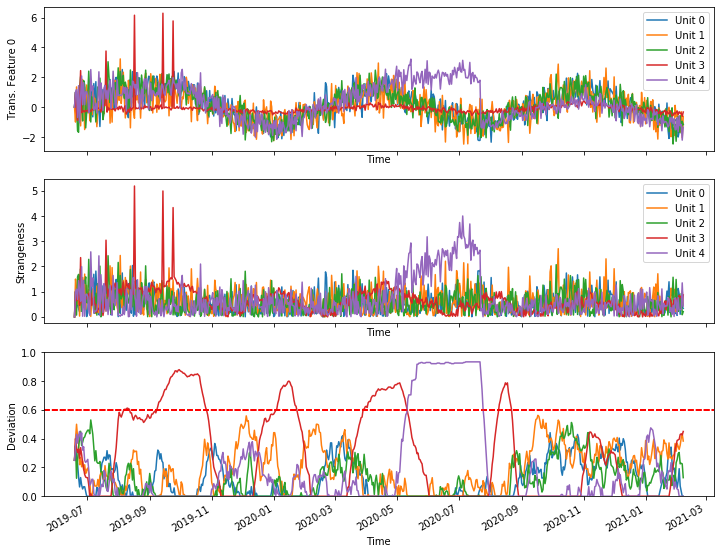

In [30]:
model = GroupAnomaly(nb_units, ids_target_units, transformer = "mean_std_normalize")

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    print(dt, end="\r", flush=True)

model.plot_deviations(figsize=(12, 10), plots=["transformed_data", "strangeness", "deviation", "threshold"])

### The slope-based normalization
Instead of a standaed mean/std or min/max normalization, another way to make the different systems more comparable is to transform the data from each system based on how much it changes over time. For example, one may compute the derivative or an estimation of the slope for each feature at each period of time, to characterize how the data is changing over time.

This can be acheived with `GroupAnomaly` by setting the parameter `transformer = "slope"` in order to estimate the slope using the last `w_transform` observed samples.

The problem with this is that the data from the different systems may have different scales. For example, as you can see from the following figure, the values of Unit 2 have a bigger scale than the other Units.

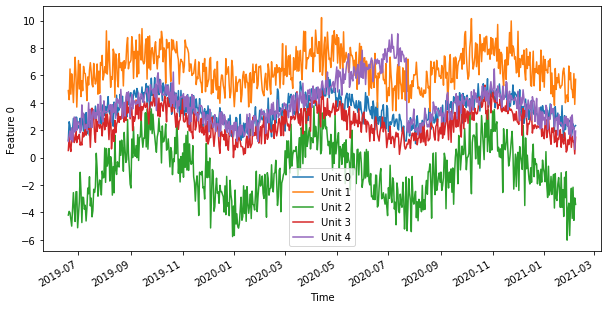

In [31]:
dataset = load_artificial(dataset_id)
dataset.plot( figsize=(10, 5) )

After running the following code, you will see that when the data from each system is transformed based on the estimated slope, then Unit 2 would be deviating most of the time (as it have a bigger slope than the others). Moreover, the transformed data may show some anomalies which are just artifacts of the slope computation (e.g. the negative slope observed for Unit 4, after the period of deviation). 

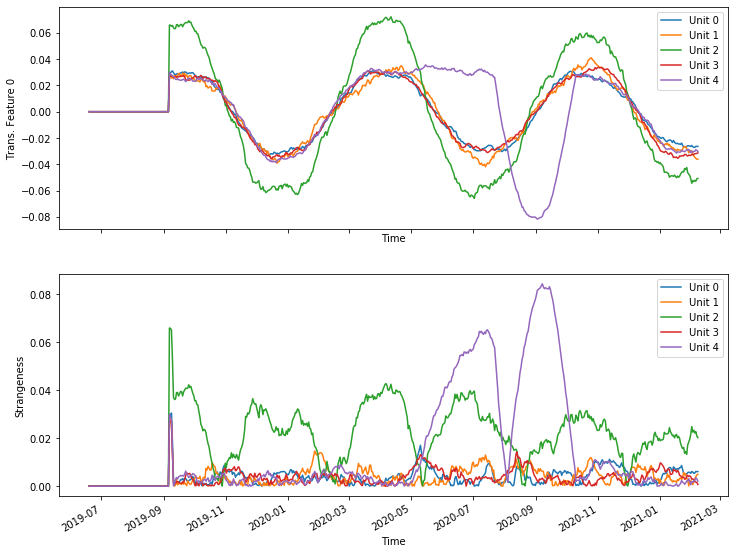

In [32]:
model = GroupAnomaly(nb_units, ids_target_units, transformer="slope", w_transform=80)

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    print(dt, end="\r", flush=True)

model.plot_deviations(figsize=(12, 10), plots=["transformed_data", "strangeness"])

### The p-value normalization
One way to overcome the above problems is to set the parameter `transformer = "pvalue"` or to `transformer = "mean_pvalue"` to characterize how each system changes based on its own historical data, without being sensitive the the scale or outliers in the data.

If we set `transformer = "pvalue"`, then each value $v_t$ from the time-series is transformed to a p-value $r_t$ which indicates where the value $v_t$ lies in the set of historical values from the same system.
$$
r_t = Pr(v < v_t) = \frac{\#\{i = 1 \dots t-1 \mid v_i < v_t\}}{t-1} \in [0, 1]
$$

If we set `transformer = "mean_pvalue"`, then each value $v_t$ from the time-series is transformed to a value $\bar{r}_t$. This value consists of the average of the last $w$ values $\{r_{t-w}, ... r_t\}$, where $w$ refers to the parameter `w_transform` of the `GroupAnomaly` class.

After running the following code, you will notice that Unit 2 is not affected by the different scale, and Unit 3 is not affected by the outliers. The transformed data of all systems looks similar (besides Unit 4 which clearly deviates during some time period).

Note: when using `transformer = "mean_pvalue"`, the transformed time-series is much more smooth, and it makes sense in this case to only compute the strangeness scores (i.e. non-conformity) without the deviation level.

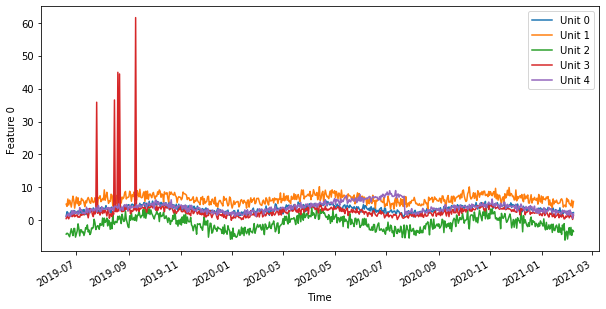

In [33]:
dataset = load_artificial(dataset_id)

# Adding few outliers to the data-stream of Unit 3
ids = np.random.randint(0, 100, size = 5)
df = dataset.dfs[3]
df.iloc[ids] = df.values[ids] * 15

dataset.plot( figsize=(10, 5) )

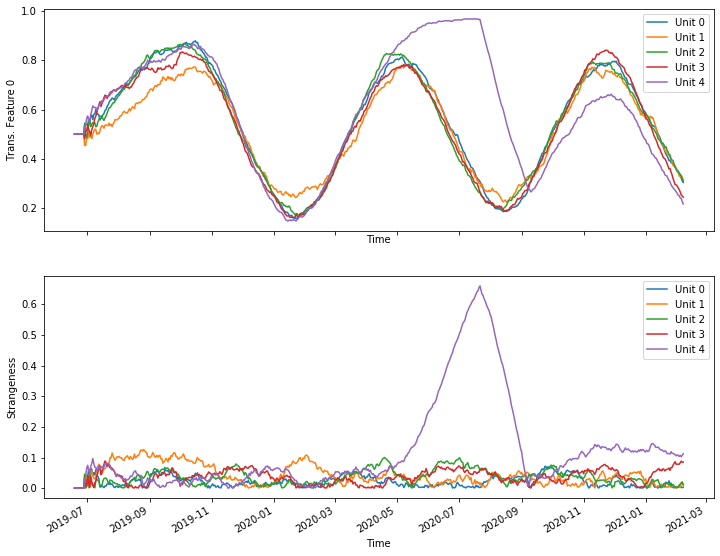

In [34]:
model = GroupAnomaly(nb_units, ids_target_units, transformer = "mean_pvalue", w_transform=50)

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    print(dt, end="\r", flush=True)

model.plot_deviations(figsize=(12, 10), plots=["transformed_data", "strangeness"])

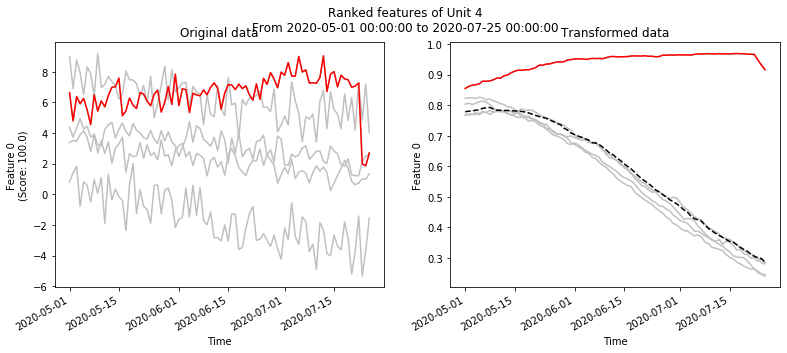

In [35]:
t1 = datetime(2020, 5, 1)
t2 = datetime(2020, 7, 25)

model.plot_explanations(uid=4, from_time=t1, to_time=t2, figsize=(13, 5))

# 4. Future

## 4.1. Interactive anomaly detection (integrating user-feedback)

From the end-user perspective, a deviation can be relevant (i.e. an actual anomaly) or irrelevant (e.g. an atypical  but normal behaviour). The user-feedback can consist in a binary label: relevant_deviation / irrelevant_deviation. 
The goal is to learn to suggest only relevant deviations, e.g. by:
- Learning a binary classification model based on the deviations characterization (currently used to search for similar deviations).
- Learning a distance metric based on the feedback and use it when computing the non-conformity measure.
- ...

## 4.2. Search for several usefull representations
Exploring a large set of features (and combinations of signales) and determining which ones lead to:
- More interesting deviations.
- More iid data accross the various systems.
- ...

<img src="imgs/features-exploration.png" width="800px" />